In [17]:
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

In [18]:
# dataset_path = 'C:\\Users\\joao_\\Documents\\Trabalho-ReconhecimentoPadroes\\datasets\\Mi3_Aligned'
dataset_path = 'D:\\Trabalho-ReconhecimentoPadroes\\datasets\\Mi3_Aligned'


In [19]:
def contar_imagens_com_dimensoes(caminho_da_pasta):
    contador = 0
    if not os.path.isdir(caminho_da_pasta):
        print(f'O caminho "{caminho_da_pasta}" não é um diretório válido.')
        return contador
    for pasta_raiz, sub_pastas, arquivos in os.walk(caminho_da_pasta):
        for arquivo in arquivos:
            if arquivo.lower().endswith(('.jpg', '.jpeg', '.png', '.gif', '.bmp')):
                caminho_completo = os.path.join(pasta_raiz, arquivo)
                try:
                    imagem = Image.open(caminho_completo)
                    largura, altura = imagem.size
                    if largura == 3000 and altura == 3000:
                        contador += 1
                except Exception as e:
                    print(f"Erro ao abrir a imagem {caminho_completo}: {str(e)}")
    print(arquivos)
    return contador

In [20]:
def cortar_imagem(image_path):
    imagem = Image.open(image_path)
    largura, altura = imagem.size
    janelas = []

    for x in range(0, largura, 300):
        for y in range(0, altura, 300):
            caixa = (x, y, x + 300, y + 300)
            janela = imagem.crop(caixa)
            janelas.append(np.array(janela))

    return janelas

In [21]:
def criar_dataset(caminho_da_pasta):
    imagens = []
    labels = []
    adicionou_ruido = False

    for pasta_raiz, sub_pastas, arquivos in os.walk(caminho_da_pasta):
        for arquivo in arquivos:
            if arquivo.endswith('Reference.bmp'):
                imagem_path = os.path.join(pasta_raiz, arquivo)
                janelas = cortar_imagem(imagem_path)
                imagem = Image.open(imagem_path)
                largura, altura = imagem.size
                if largura == 3000 and altura == 3000:
                    imagens.extend(janelas)
                    labels.extend([0] * len(janelas))
                # print('imagem refernce', arquivo)
            elif arquivo.endswith('Noisy.bmp') and not adicionou_ruido:
                imagem_path = os.path.join(pasta_raiz, arquivo)
                janelas = cortar_imagem(imagem_path)
                imagem = Image.open(imagem_path)
                largura, altura = imagem.size
                if largura == 3000 and altura == 3000:
                    imagens.extend(janelas)
                    labels.extend([1] * len(janelas))
                    adicionou_ruido = True
                    # print('imagem noisy', arquivo)
        adicionou_ruido = False

    return np.array(imagens), np.array(labels)

In [22]:
## caso queira plotar as imagens e labels para confirmar

def plotar_imagens_com_labels(imagens, labels):
    if len(imagens) != len(labels):
        raise ValueError("O número de imagens deve ser igual ao número de labels.")
    num_imagens = len(imagens)
    num_colunas = 4
    fig, axs = plt.subplots(1, num_colunas, figsize=(16, 4))
    for i in range(num_imagens):
        imagem = imagens[i]
        label = labels[i]
        axs[i % num_colunas].imshow(imagem, cmap='gray')
        axs[i % num_colunas].set_title(f'Label: {label}')
        axs[i % num_colunas].axis('off')
        if i % num_colunas == num_colunas - 1 or i == num_imagens - 1:
            plt.tight_layout()
            # plt.show()
            plt.savefig(f'plots/plot_{i}.png')
            if i != num_imagens - 1:
                fig, axs = plt.subplots(1, num_colunas, figsize=(16, 4))


In [23]:
## remontar imagem, caso queira checar


def remontar_imagem(janelas, largura_original, altura_original):
    num_janelas, altura_janela, largura_janela, _ = janelas.shape
    janelas_por_linha = largura_original // largura_janela
    imagem_remontada = np.zeros((altura_original, largura_original, 3), dtype=np.uint8)
    for i in range(num_janelas):
        linha = i // janelas_por_linha
        coluna = i % janelas_por_linha
        x1 = coluna * largura_janela
        x2 = x1 + largura_janela
        y1 = linha * altura_janela
        y2 = y1 + altura_janela
        # imagem_remontada[y1:y2, x1:x2, :] = janelas[i]
        imagem_remontada[x1:x2, y1:y2, :] = janelas[i]
    return imagem_remontada

In [24]:
imagens, labels = criar_dataset(dataset_path)

In [25]:
imagens.shape

(5600, 300, 300, 3)

In [9]:
# plotar_imagens_com_labels(imagens, labels)

C:\Users\joao_\AppData\Local\Temp\ipykernel_7416\748653295.py:20: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(1, num_colunas, figsize=(16, 4))


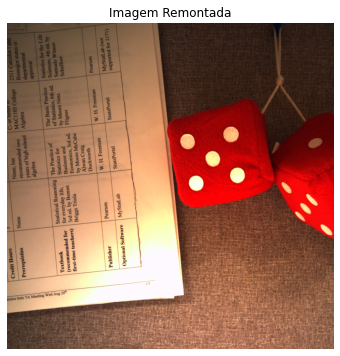

In [26]:
primeira_imagem = imagens[:100]
imagem_remontada = remontar_imagem(primeira_imagem, 3000, 3000)

# Plote a imagem remontada
plt.figure(figsize=(6, 6))
plt.imshow(imagem_remontada)
plt.title("Imagem Remontada")
plt.axis('off')
plt.show()

In [27]:
labels.shape

(5600,)

In [28]:
counter = 0
for i in range(labels.shape[0]):
    if labels[i] == 1:
        counter +=1

print('tamanho do array', labels.shape)
print('quantidade de ruido', counter)

tamanho do array (5600,)
quantidade de ruido 2800


In [29]:
np.save("images.npy", imagens)
np.save("labels.npy", labels)